In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_member import Member
from core.ga.ga_params import GeneticAlgorithmParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.plotting.plotting import plot_crop_growth_results
from core.plotting.plotting_params import PlottingParams
from core.plotting.plotting_colors import PlottingColors

# Apply plotting style (LaTeX + color-blind friendly)
plotting_params = PlottingParams()
plotting_colors = PlottingColors()
plotting_colors.apply_as_default()

## Analysis across runs

In [2]:
ga_parallel_results_folder = "ga_parallel_results"
pickled_results_folder     = "pickled_ga_results"
values_costs_folder        = "unique_values_costs_results"
input_disturbances_csv     = "io/inputs/hourly_prcp_rad_temp_iowa.csv"

## Convergence Analysis

Plot the best revenue over generations for each of the 10 GA runs.

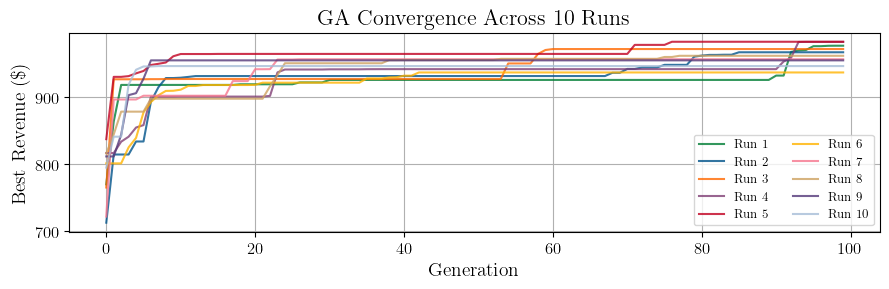


Final best revenue by run:
  Run 1: $977.10
  Run 2: $967.29
  Run 3: $972.12
  Run 4: $982.87
  Run 5: $983.04
  Run 6: $937.07
  Run 7: $956.84
  Run 8: $962.01
  Run 9: $955.18
  Run 10: $946.63


In [3]:
# Load pickled GA results and plot convergence
fig, ax = plt.subplots(figsize=(9, 3))

# Color palette for 10 runs (using color-blind friendly colors)
run_colors = [
    plotting_colors.vivid_green,
    plotting_colors.strong_blue,
    plotting_colors.vivid_orange,
    plotting_colors.strong_purple,
    plotting_colors.vivid_red,
    plotting_colors.vivid_yellow,
    plotting_colors.strong_purplish_pink,
    plotting_colors.grayish_yellow,
    plotting_colors.deep_purple,
    plotting_colors.very_light_blue,
]

for i in range(1, 11):
    pkl_path = os.path.join(
        ga_parallel_results_folder,
        pickled_results_folder,
        f"ga_parallel_result_{i}.pkl"
    )
    
    with open(pkl_path, 'rb') as f:
        ga_result = pickle.load(f)
    
    # Convert costs to revenues (negate)
    generations = range(len(ga_result.lowest_costs))
    revenues = [-c for c in ga_result.lowest_costs]
    
    ax.plot(generations, revenues, color=run_colors[i-1], linewidth=1.5, 
            alpha=0.8, label=f'Run {i}')

ax.set_xlabel('Generation')
ax.set_ylabel('Best Revenue (\\$)')
ax.set_title('GA Convergence Across 10 Runs')
ax.legend(loc='lower right', ncol=2, fontsize=9)

plt.tight_layout()
plt.savefig('ga_parallel_results/ga_convergence_all_runs.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final revenues for each run
print("\nFinal best revenue by run:")
for i in range(1, 11):
    pkl_path = os.path.join(
        ga_parallel_results_folder,
        pickled_results_folder,
        f"ga_parallel_result_{i}.pkl"
    )
    with open(pkl_path, 'rb') as f:
        ga_result = pickle.load(f)
    final_revenue = -ga_result.lowest_costs[-1]
    print(f"  Run {i}: ${final_revenue:.2f}")

## Growth analysis - Best in the final populations

In [4]:
# Set up Member attributes common to all runs
ga_params = GeneticAlgorithmParams()
carrying_capacities = ModelCarryingCapacities()
input_disturbances = ModelDisturbances.from_defaults(path=os.path.join(project_root, input_disturbances_csv))
growth_rates = ModelGrowthRates()
model_params = ModelParams(verbose=True)
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)
default_typical_disturbances = ModelTypicalDisturbances()
typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)
sensitivities = ModelSensitivities()

Analyzing best member from run 1...
Revenue: $885.5707006839069 with inputs: IF=1652.6121394654, IA=3.8298749849, FF=1950.3157100932, FA=175.1697337318
Height: 2.7460964056740518, Leaf area: 0.525971207159523, Fruit biomass: 0.2128699929773205
Analyzing best member from run 2...
Revenue: $778.0405228634704 with inputs: IF=1439.7951184779, IA=4.9603162277, FF=1902.4516433096, FA=201.3493100558
Height: 2.847274015327771, Leaf area: 0.507159946155139, Fruit biomass: 0.1961596915389813
Analyzing best member from run 3...
Revenue: $909.1737856616032 with inputs: IF=1696.2854928388, IA=5.6140771022, FF=2183.5985146911, FA=205.4117123493
Height: 2.746825881339302, Leaf area: 0.4842646120009951, Fruit biomass: 0.1950114002294962
Analyzing best member from run 4...
Revenue: $983.3439532750775 with inputs: IF=1236.7362895452, IA=4.9896961931, FF=803.2474625247, FA=76.7713014035
Height: 2.8363169866583955, Leaf area: 0.5012024092201566, Fruit biomass: 0.191729560897363
Analyzing best member from 

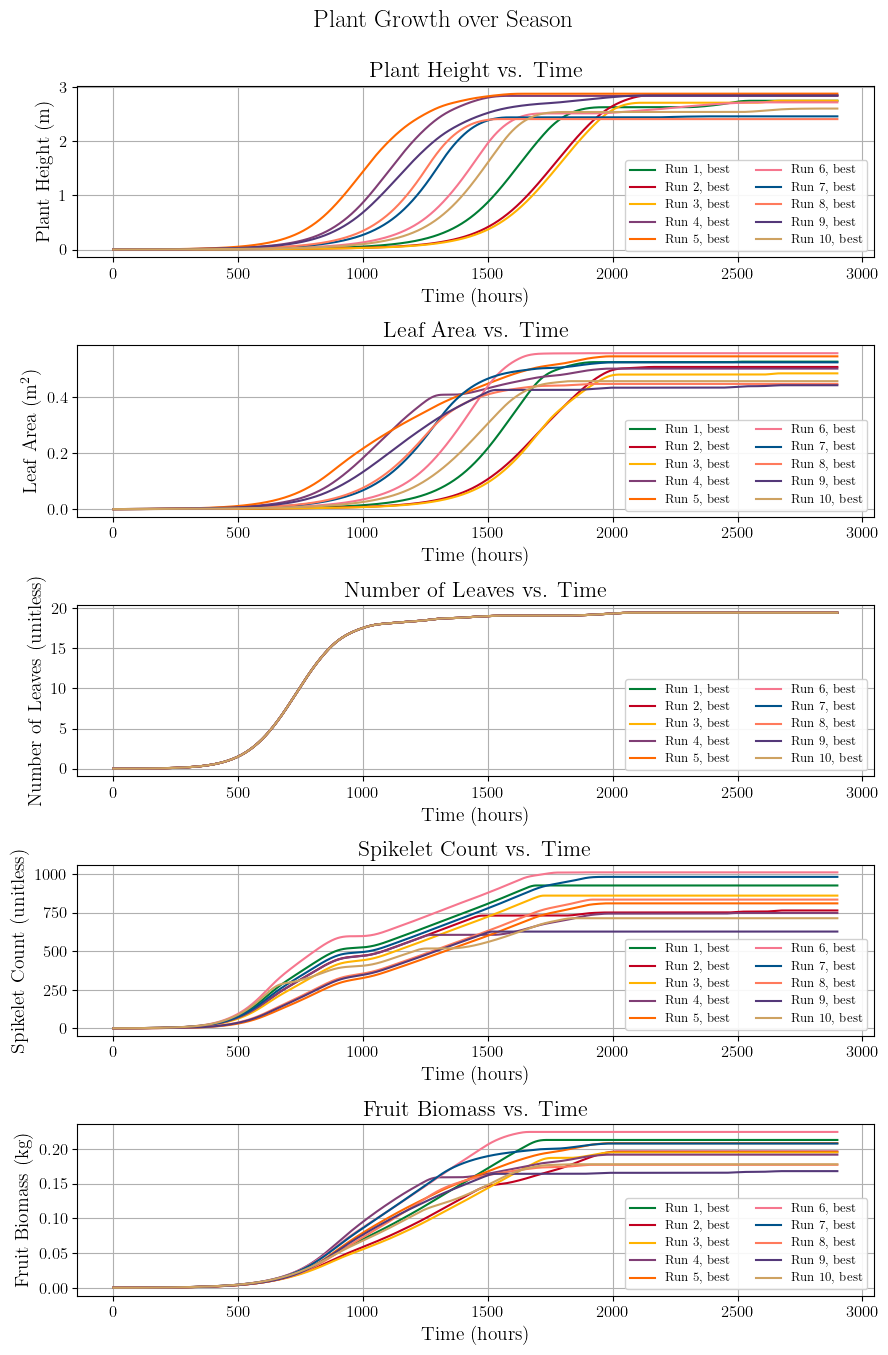

In [5]:
# Initialize storage of state variables for all runs
hs = []
As = []
Ns = []
cs = []
Ps = []
labels = []

# Loop over all 10 of the best runs to analyze plant growth
for i in range(1, 11): # Runs 1 to 10

    print(f"Analyzing best member from run {i}...")

    # Load the best member's input values from the corresponding CSV file
    values_costs_path = os.path.join(
        ga_parallel_results_folder,
        values_costs_folder,
        f"ga_parallel_result_unique_values_and_costs_{i}.csv"
    )
    with open(values_costs_path, "rb") as f:
        unique_values_costs = np.loadtxt(f, delimiter=",", skiprows=1)

    best_index = np.argmax(unique_values_costs[:, -1])  # The last column is the revenue
    revenue = unique_values_costs[best_index, -1]
    irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount = unique_values_costs[best_index, 0:4]
    print(f'Revenue: ${revenue} with inputs: IF={irrigation_frequency}, IA={irrigation_amount}, FF={fertilizer_frequency}, FA={fertilizer_amount}')
    
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = input_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
    )
    member.get_cost()

    # Read output CSV
    output = pd.read_csv('output_get_cost.csv')

    hs.append(output['h'].to_numpy())
    As.append(output['A'].to_numpy())
    Ns.append(output['N'].to_numpy())
    cs.append(output['c'].to_numpy())
    Ps.append(output['P'].to_numpy())
    labels.append(f'Run {i}, best')
    print(f'Height: {hs[-1][-1]}, Leaf area: {As[-1][-1]}, Fruit biomass: {Ps[-1][-1]}')

plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    labels=labels
)

## Growth analysis - Worst in the final populations

Analyzing worst member from run 1...
Revenue: $-19464.025609694756 with inputs: IF=1149.4944894058, IA=9.315804827, FF=56.560759349, FA=619.8058038942
Height: 0.0012425786403057, Leaf area: 0.0002626570776708, Fruit biomass: 0.0002176423883386
Analyzing worst member from run 2...
Revenue: $-34112.44229762581 with inputs: IF=63.4070190458, IA=6.8986224569, FF=35.0376195037, FA=673.1458799615
Height: 0.0011655398685768, Leaf area: 0.0002512378987067, Fruit biomass: 0.000159540981207
Analyzing worst member from run 3...
Revenue: $-22295.905400785457 with inputs: IF=2884.0997933255, IA=7.848628083, FF=24.0723201119, FA=312.6050074535
Height: 0.0014019369363633, Leaf area: 0.0003023996808859, Fruit biomass: 0.0003075807252923
Analyzing worst member from run 4...
Revenue: $-7414.255618999078 with inputs: IF=122.6066832032, IA=3.5413585046, FF=137.0694690326, FA=536.3450625228
Height: 0.0015094592626936, Leaf area: 0.0003306510197591, Fruit biomass: 0.0007148389175204
Analyzing worst member f

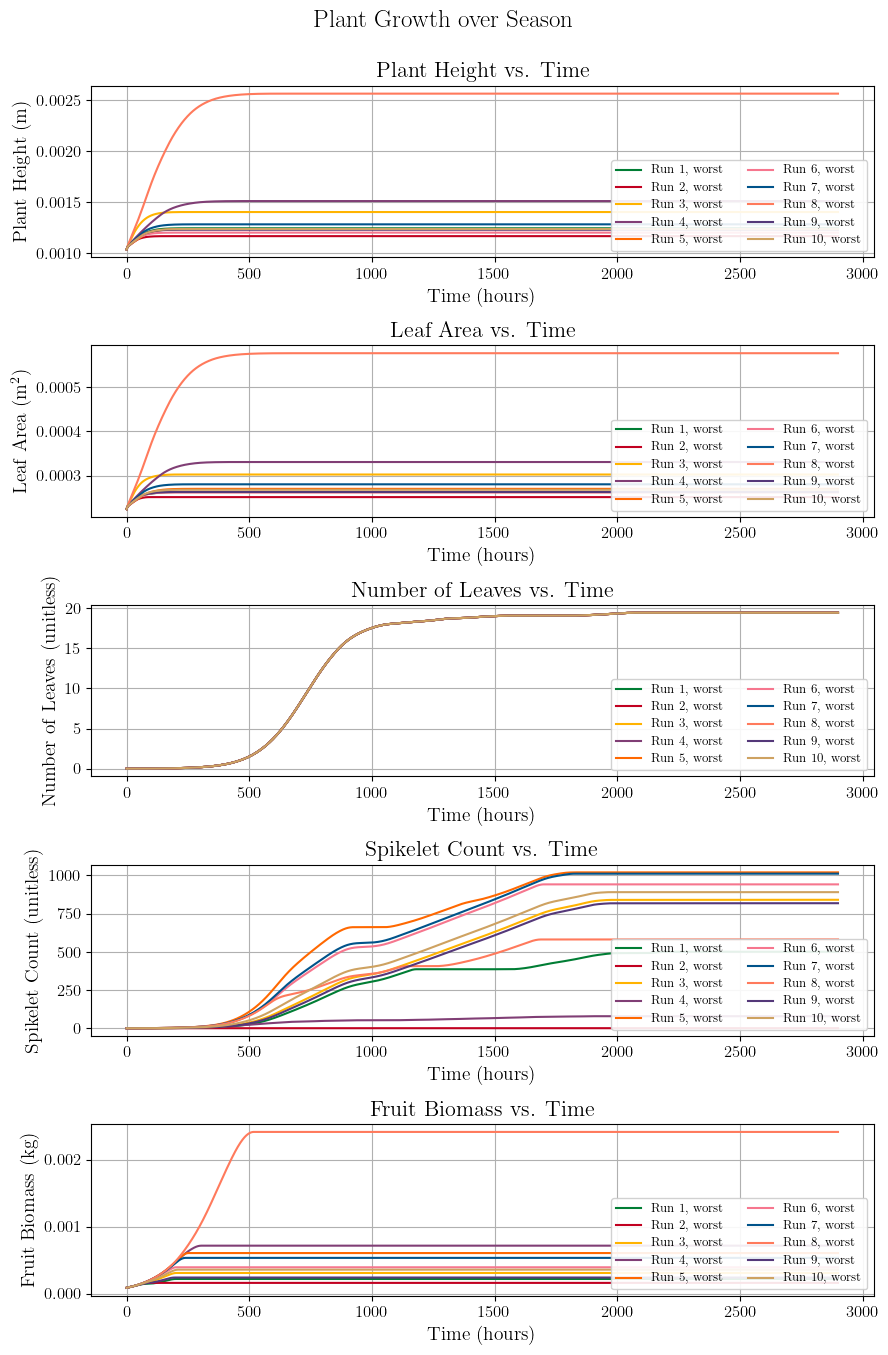

In [6]:
# Initialize storage of state variables for all runs
hs = []
As = []
Ns = []
cs = []
Ps = []
labels = []

# Loop over all 10 of the best runs to analyze plant growth
for i in range(1, 11): # Runs 1 to 10

    print(f"Analyzing worst member from run {i}...")

    # Load the worst member's input values from the corresponding CSV file
    values_costs_path = os.path.join(
        ga_parallel_results_folder,
        values_costs_folder,
        f"ga_parallel_result_unique_values_and_costs_{i}.csv"
    )
    with open(values_costs_path, "rb") as f:
        unique_values_costs = np.loadtxt(f, delimiter=",", skiprows=1)

    worst_index = np.argmin(unique_values_costs[:, -1])  # The last column is the revenue
    revenue = unique_values_costs[worst_index, -1]
    irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount = unique_values_costs[worst_index, 0:4]
    print(f'Revenue: ${revenue} with inputs: IF={irrigation_frequency}, IA={irrigation_amount}, FF={fertilizer_frequency}, FA={fertilizer_amount}')
    
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = input_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
    )
    member.get_cost()

    # Read output CSV
    output = pd.read_csv('output_get_cost.csv')

    hs.append(output['h'].to_numpy())
    As.append(output['A'].to_numpy())
    Ns.append(output['N'].to_numpy())
    cs.append(output['c'].to_numpy())
    Ps.append(output['P'].to_numpy())
    labels.append(f'Run {i}, worst')
    print(f'Height: {hs[-1][-1]}, Leaf area: {As[-1][-1]}, Fruit biomass: {Ps[-1][-1]}')

plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    labels=labels
)